In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/glass')
mask_dir = os.path.join(dataset_dir,'mask/glass')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/glass C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/glass
13135
13135


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-13 13:28:43,726: INFO: 3804955329: date_time: 20250213-132843]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet34", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-13 13:28:43,842: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-13 13:28:43,842: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet34', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-13 13:28:43,843: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-13 13:28:43,843: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

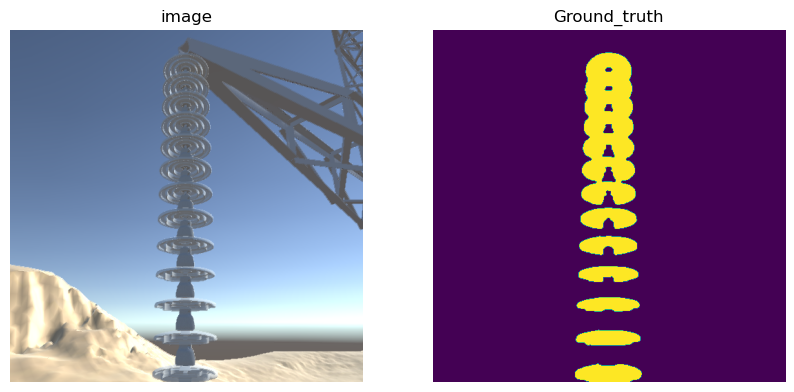

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-13 13:28:44,172: INFO: 3993860970: data injection started]
[2025-02-13 13:28:44,173: INFO: 3993860970: train data spliting ]
[2025-02-13 13:28:44,175: INFO: 3993860970: val test spliting ]
[2025-02-13 13:28:44,176: INFO: 3993860970: csv saving started]
[2025-02-13 13:28:44,191: INFO: 3993860970: train csv done ]
[2025-02-13 13:28:44,194: INFO: 3993860970: val csv done ]
[2025-02-13 13:28:44,197: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [16]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score_for_training.append(mean_miou_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 1752/1752 [04:55<00:00,  5.92it/s, epoch=0, train_loss=0.0145, train_Miou_score=0.53, train_dice_score=0.613, train_acc=0.991, train_binary_jaccard_index=0.862] 

[2025-02-13 13:33:40,403: INFO: 2245122998: Epoch: 0 | Training_Loss: 0.01452855677365168]
[2025-02-13 13:33:40,403: INFO: 2245122998: train_binary_jaccard_index: 0.862266638626655]
[2025-02-13 13:33:40,404: INFO: 2245122998: train_loss 0.03929515439700147]
[2025-02-13 13:33:40,404: INFO: 2245122998: train_Miou_score 0.529573751124447]
[2025-02-13 13:33:40,404: INFO: 2245122998: train_dice_score 0.6132493585414045]
[2025-02-13 13:33:40,405: INFO: 2245122998: train_acc 0.990647294886036]



100%|██████████| 657/657 [00:37<00:00, 17.66it/s, epoch=0, eval_loss=0.00567, eval_Miou_score=0.551, eval_dice_score=0.706, eval_acc=0.995, eval_binary_jaccard_index=0.905]

[2025-02-13 13:34:17,611: INFO: 2245122998: Epoch: 0 | Loss: 0.005672975580804787]
[2025-02-13 13:34:17,612: INFO: 2245122998: eval_binary_jaccard_index: 0.9054458415762293]
[2025-02-13 13:34:17,612: INFO: 2245122998: eval_loss 0.005647556514069978]
[2025-02-13 13:34:17,612: INFO: 2245122998: eval_Miou_score 0.550900284285959]
[2025-02-13 13:34:17,613: INFO: 2245122998: eval_dice_score 0.7061272412311722]
[2025-02-13 13:34:17,613: INFO: 2245122998: eval_acc 0.9945007190675315]



100%|██████████| 1752/1752 [03:42<00:00,  7.88it/s, epoch=1, train_loss=0.00488, train_Miou_score=0.546, train_dice_score=0.654, train_acc=0.993, train_binary_jaccard_index=0.891]

[2025-02-13 13:38:00,058: INFO: 2245122998: Epoch: 1 | Training_Loss: 0.004878935646520902]
[2025-02-13 13:38:00,058: INFO: 2245122998: train_binary_jaccard_index: 0.8912154574746682]
[2025-02-13 13:38:00,058: INFO: 2245122998: train_loss 0.022076192453546275]
[2025-02-13 13:38:00,059: INFO: 2245122998: train_Miou_score 0.5456936091724698]
[2025-02-13 13:38:00,059: INFO: 2245122998: train_dice_score 0.6536866549809663]
[2025-02-13 13:38:00,060: INFO: 2245122998: train_acc 0.9929360535897348]



100%|██████████| 657/657 [00:21<00:00, 30.19it/s, epoch=1, eval_loss=0.00388, eval_Miou_score=0.561, eval_dice_score=0.719, eval_acc=0.995, eval_binary_jaccard_index=0.918]

[2025-02-13 13:38:21,819: INFO: 2245122998: Epoch: 1 | Loss: 0.0038848455819546542]
[2025-02-13 13:38:21,819: INFO: 2245122998: eval_binary_jaccard_index: 0.9175073449787665]
[2025-02-13 13:38:21,821: INFO: 2245122998: eval_loss 0.00474932136635963]
[2025-02-13 13:38:21,821: INFO: 2245122998: eval_Miou_score 0.5605100714452734]
[2025-02-13 13:38:21,821: INFO: 2245122998: eval_dice_score 0.7193801691543021]
[2025-02-13 13:38:21,822: INFO: 2245122998: eval_acc 0.9953445147161615]



100%|██████████| 1752/1752 [03:44<00:00,  7.81it/s, epoch=2, train_loss=0.00403, train_Miou_score=0.553, train_dice_score=0.675, train_acc=0.994, train_binary_jaccard_index=0.905]

[2025-02-13 13:42:06,166: INFO: 2245122998: Epoch: 2 | Training_Loss: 0.004033261476314231]


[2025-02-13 13:42:06,167: INFO: 2245122998: train_binary_jaccard_index: 0.9050195780915847]
[2025-02-13 13:42:06,167: INFO: 2245122998: train_loss 0.016096525903412522]
[2025-02-13 13:42:06,168: INFO: 2245122998: train_Miou_score 0.5533749548196679]
[2025-02-13 13:42:06,168: INFO: 2245122998: train_dice_score 0.6747627294486986]
[2025-02-13 13:42:06,168: INFO: 2245122998: train_acc 0.9939636877387807]


100%|██████████| 657/657 [00:21<00:00, 29.95it/s, epoch=2, eval_loss=0.0035, eval_Miou_score=0.564, eval_dice_score=0.726, eval_acc=0.996, eval_binary_jaccard_index=0.924] 

[2025-02-13 13:42:28,106: INFO: 2245122998: Epoch: 2 | Loss: 0.003496144823106275]
[2025-02-13 13:42:28,106: INFO: 2245122998: eval_binary_jaccard_index: 0.9239128898661008]
[2025-02-13 13:42:28,107: INFO: 2245122998: eval_loss 0.004346488745573724]
[2025-02-13 13:42:28,107: INFO: 2245122998: eval_Miou_score 0.5641398925819958]
[2025-02-13 13:42:28,107: INFO: 2245122998: eval_dice_score 0.7264740505628571]
[2025-02-13 13:42:28,108: INFO: 2245122998: eval_acc 0.9957433455731892]



100%|██████████| 1752/1752 [03:44<00:00,  7.81it/s, epoch=3, train_loss=0.00412, train_Miou_score=0.557, train_dice_score=0.685, train_acc=0.994, train_binary_jaccard_index=0.912]

[2025-02-13 13:46:12,576: INFO: 2245122998: Epoch: 3 | Training_Loss: 0.004117645017088276]
[2025-02-13 13:46:12,577: INFO: 2245122998: train_binary_jaccard_index: 0.9115701847280201]
[2025-02-13 13:46:12,577: INFO: 2245122998: train_loss 0.013045669340764171]
[2025-02-13 13:46:12,577: INFO: 2245122998: train_Miou_score 0.5571734217031684]
[2025-02-13 13:46:12,578: INFO: 2245122998: train_dice_score 0.6853568491291523]
[2025-02-13 13:46:12,578: INFO: 2245122998: train_acc 0.9944502899516799]



100%|██████████| 657/657 [00:22<00:00, 29.59it/s, epoch=3, eval_loss=0.0036, eval_Miou_score=0.567, eval_dice_score=0.729, eval_acc=0.996, eval_binary_jaccard_index=0.926] 

[2025-02-13 13:46:34,785: INFO: 2245122998: Epoch: 3 | Loss: 0.003597312140501072]
[2025-02-13 13:46:34,786: INFO: 2245122998: eval_binary_jaccard_index: 0.9264100431670156]
[2025-02-13 13:46:34,786: INFO: 2245122998: eval_loss 0.0041293821344594505]
[2025-02-13 13:46:34,787: INFO: 2245122998: eval_Miou_score 0.5669077892803347]
[2025-02-13 13:46:34,787: INFO: 2245122998: eval_dice_score 0.7288752582315441]
[2025-02-13 13:46:34,787: INFO: 2245122998: eval_acc 0.9959137138529274]



100%|██████████| 1752/1752 [03:42<00:00,  7.86it/s, epoch=4, train_loss=0.00339, train_Miou_score=0.561, train_dice_score=0.696, train_acc=0.995, train_binary_jaccard_index=0.918]

[2025-02-13 13:50:17,775: INFO: 2245122998: Epoch: 4 | Training_Loss: 0.0033856410550200233]
[2025-02-13 13:50:17,775: INFO: 2245122998: train_binary_jaccard_index: 0.9177275544126012]


[2025-02-13 13:50:17,776: INFO: 2245122998: train_loss 0.011137079351529295]
[2025-02-13 13:50:17,776: INFO: 2245122998: train_Miou_score 0.5607419974719212]
[2025-02-13 13:50:17,777: INFO: 2245122998: train_dice_score 0.6955729559614625]
[2025-02-13 13:50:17,777: INFO: 2245122998: train_acc 0.9948868201815919]


100%|██████████| 657/657 [00:21<00:00, 30.33it/s, epoch=4, eval_loss=0.00325, eval_Miou_score=0.569, eval_dice_score=0.733, eval_acc=0.996, eval_binary_jaccard_index=0.929]

[2025-02-13 13:50:39,441: INFO: 2245122998: Epoch: 4 | Loss: 0.003248578790841763]
[2025-02-13 13:50:39,442: INFO: 2245122998: eval_binary_jaccard_index: 0.9289013586813638]
[2025-02-13 13:50:39,442: INFO: 2245122998: eval_loss 0.003977158216936829]
[2025-02-13 13:50:39,442: INFO: 2245122998: eval_Miou_score 0.5686218974071369]
[2025-02-13 13:50:39,443: INFO: 2245122998: eval_dice_score 0.7326059741788803]
[2025-02-13 13:50:39,443: INFO: 2245122998: eval_acc 0.9960845720822409]



100%|██████████| 1752/1752 [03:43<00:00,  7.84it/s, epoch=5, train_loss=0.00324, train_Miou_score=0.563, train_dice_score=0.703, train_acc=0.995, train_binary_jaccard_index=0.922]

[2025-02-13 13:54:22,856: INFO: 2245122998: Epoch: 5 | Training_Loss: 0.0032361631524072936]
[2025-02-13 13:54:22,857: INFO: 2245122998: train_binary_jaccard_index: 0.9221502059597176]
[2025-02-13 13:54:22,857: INFO: 2245122998: train_loss 0.009849296481458384]
[2025-02-13 13:54:22,858: INFO: 2245122998: train_Miou_score 0.5634451216672188]
[2025-02-13 13:54:22,858: INFO: 2245122998: train_dice_score 0.7032069576515417]
[2025-02-13 13:54:22,858: INFO: 2245122998: train_acc 0.9952017933617897]



100%|██████████| 657/657 [00:22<00:00, 29.43it/s, epoch=5, eval_loss=0.00294, eval_Miou_score=0.571, eval_dice_score=0.738, eval_acc=0.996, eval_binary_jaccard_index=0.931]

[2025-02-13 13:54:45,184: INFO: 2245122998: Epoch: 5 | Loss: 0.0029386739208273694]
[2025-02-13 13:54:45,185: INFO: 2245122998: eval_binary_jaccard_index: 0.9313447194042573]
[2025-02-13 13:54:45,185: INFO: 2245122998: eval_loss 0.0037990436131907115]
[2025-02-13 13:54:45,185: INFO: 2245122998: eval_Miou_score 0.5708134829514163]
[2025-02-13 13:54:45,186: INFO: 2245122998: eval_dice_score 0.7375689200312278]
[2025-02-13 13:54:45,186: INFO: 2245122998: eval_acc 0.9962491393996519]



100%|██████████| 1752/1752 [03:43<00:00,  7.84it/s, epoch=6, train_loss=0.00299, train_Miou_score=0.566, train_dice_score=0.71, train_acc=0.995, train_binary_jaccard_index=0.926] 

[2025-02-13 13:58:28,525: INFO: 2245122998: Epoch: 6 | Training_Loss: 0.002989666612997447]


[2025-02-13 13:58:28,526: INFO: 2245122998: train_binary_jaccard_index: 0.9259147900536374]
[2025-02-13 13:58:28,526: INFO: 2245122998: train_loss 0.008866079958424693]
[2025-02-13 13:58:28,526: INFO: 2245122998: train_Miou_score 0.565921144414783]
[2025-02-13 13:58:28,527: INFO: 2245122998: train_dice_score 0.7103405718666436]
[2025-02-13 13:58:28,527: INFO: 2245122998: train_acc 0.9954614585966591]


100%|██████████| 657/657 [00:22<00:00, 28.69it/s, epoch=6, eval_loss=0.00299, eval_Miou_score=0.573, eval_dice_score=0.741, eval_acc=0.996, eval_binary_jaccard_index=0.933]

[2025-02-13 13:58:51,430: INFO: 2245122998: Epoch: 6 | Loss: 0.00298761232802857]
[2025-02-13 13:58:51,430: INFO: 2245122998: eval_binary_jaccard_index: 0.9330938844013069]
[2025-02-13 13:58:51,431: INFO: 2245122998: eval_loss 0.003682373413334905]
[2025-02-13 13:58:51,431: INFO: 2245122998: eval_Miou_score 0.5725595916929803]
[2025-02-13 13:58:51,431: INFO: 2245122998: eval_dice_score 0.7410829546309523]
[2025-02-13 13:58:51,432: INFO: 2245122998: eval_acc 0.9963592658692999]



100%|██████████| 1752/1752 [03:43<00:00,  7.85it/s, epoch=7, train_loss=0.00349, train_Miou_score=0.567, train_dice_score=0.714, train_acc=0.996, train_binary_jaccard_index=0.928]

[2025-02-13 14:02:34,735: INFO: 2245122998: Epoch: 7 | Training_Loss: 0.0034931460267876926]
[2025-02-13 14:02:34,736: INFO: 2245122998: train_binary_jaccard_index: 0.9277670106459324]
[2025-02-13 14:02:34,736: INFO: 2245122998: train_loss 0.008246351072460642]
[2025-02-13 14:02:34,737: INFO: 2245122998: train_Miou_score 0.5673122381335379]
[2025-02-13 14:02:34,737: INFO: 2245122998: train_dice_score 0.7144466980691887]
[2025-02-13 14:02:34,738: INFO: 2245122998: train_acc 0.9955933702616319]



100%|██████████| 657/657 [00:21<00:00, 30.12it/s, epoch=7, eval_loss=0.00295, eval_Miou_score=0.574, eval_dice_score=0.744, eval_acc=0.996, eval_binary_jaccard_index=0.934]

[2025-02-13 14:02:56,555: INFO: 2245122998: Epoch: 7 | Loss: 0.0029536246164748657]
[2025-02-13 14:02:56,555: INFO: 2245122998: eval_binary_jaccard_index: 0.9344968434899501]
[2025-02-13 14:02:56,556: INFO: 2245122998: eval_loss 0.0036205704683586947]
[2025-02-13 14:02:56,556: INFO: 2245122998: eval_Miou_score 0.5742790552545084]
[2025-02-13 14:02:56,557: INFO: 2245122998: eval_dice_score 0.743533148715213]
[2025-02-13 14:02:56,557: INFO: 2245122998: eval_acc 0.996446068065533]



100%|██████████| 1752/1752 [03:44<00:00,  7.82it/s, epoch=8, train_loss=0.00281, train_Miou_score=0.569, train_dice_score=0.72, train_acc=0.996, train_binary_jaccard_index=0.93]  

[2025-02-13 14:06:40,582: INFO: 2245122998: Epoch: 8 | Training_Loss: 0.0028057327349436337]
[2025-02-13 14:06:40,583: INFO: 2245122998: train_binary_jaccard_index: 0.9304157749578198]
[2025-02-13 14:06:40,583: INFO: 2245122998: train_loss 0.007642818008252156]
[2025-02-13 14:06:40,583: INFO: 2245122998: train_Miou_score 0.5691914857846682]
[2025-02-13 14:06:40,584: INFO: 2245122998: train_dice_score 0.7199333502953794]
[2025-02-13 14:06:40,585: INFO: 2245122998: train_acc 0.995771957537748]



100%|██████████| 657/657 [00:21<00:00, 30.01it/s, epoch=8, eval_loss=0.00616, eval_Miou_score=0.571, eval_dice_score=0.735, eval_acc=0.996, eval_binary_jaccard_index=0.93] 

[2025-02-13 14:07:02,482: INFO: 2245122998: Epoch: 8 | Loss: 0.006159646598171426]
[2025-02-13 14:07:02,482: INFO: 2245122998: eval_binary_jaccard_index: 0.9299049523781746]
[2025-02-13 14:07:02,483: INFO: 2245122998: eval_loss 0.003883088595414276]
[2025-02-13 14:07:02,483: INFO: 2245122998: eval_Miou_score 0.5710449849497782]
[2025-02-13 14:07:02,484: INFO: 2245122998: eval_dice_score 0.735166714366531]
[2025-02-13 14:07:02,484: INFO: 2245122998: eval_acc 0.9961574482833111]



100%|██████████| 1752/1752 [03:43<00:00,  7.84it/s, epoch=9, train_loss=0.00299, train_Miou_score=0.571, train_dice_score=0.724, train_acc=0.996, train_binary_jaccard_index=0.932]

[2025-02-13 14:10:46,082: INFO: 2245122998: Epoch: 9 | Training_Loss: 0.0029909460716051597]
[2025-02-13 14:10:46,083: INFO: 2245122998: train_binary_jaccard_index: 0.9322349606464578]
[2025-02-13 14:10:46,083: INFO: 2245122998: train_loss 0.007212791387907266]
[2025-02-13 14:10:46,083: INFO: 2245122998: train_Miou_score 0.5705723474265744]
[2025-02-13 14:10:46,084: INFO: 2245122998: train_dice_score 0.7238864063403301]
[2025-02-13 14:10:46,084: INFO: 2245122998: train_acc 0.9958962511254228]



100%|██████████| 657/657 [00:22<00:00, 29.48it/s, epoch=9, eval_loss=0.00258, eval_Miou_score=0.573, eval_dice_score=0.739, eval_acc=0.996, eval_binary_jaccard_index=0.932]

[2025-02-13 14:11:08,374: INFO: 2245122998: Epoch: 9 | Loss: 0.0025771929793161888]
[2025-02-13 14:11:08,374: INFO: 2245122998: eval_binary_jaccard_index: 0.9319666087876898]
[2025-02-13 14:11:08,375: INFO: 2245122998: eval_loss 0.0037525282632904625]
[2025-02-13 14:11:08,375: INFO: 2245122998: eval_Miou_score 0.5728062934958046]
[2025-02-13 14:11:08,375: INFO: 2245122998: eval_dice_score 0.7393634561239494]
[2025-02-13 14:11:08,376: INFO: 2245122998: eval_acc 0.9962845179588283]



100%|██████████| 1752/1752 [03:43<00:00,  7.83it/s, epoch=10, train_loss=0.00301, train_Miou_score=0.572, train_dice_score=0.727, train_acc=0.996, train_binary_jaccard_index=0.934]

[2025-02-13 14:14:52,227: INFO: 2245122998: Epoch: 10 | Training_Loss: 0.0030096460422968756]
[2025-02-13 14:14:52,227: INFO: 2245122998: train_binary_jaccard_index: 0.9336868484143822]
[2025-02-13 14:14:52,228: INFO: 2245122998: train_loss 0.006824801971336563]
[2025-02-13 14:14:52,228: INFO: 2245122998: train_Miou_score 0.5716167499426089]


[2025-02-13 14:14:52,229: INFO: 2245122998: train_dice_score 0.7271374120612251]
[2025-02-13 14:14:52,229: INFO: 2245122998: train_acc 0.9959962502394093]


100%|██████████| 657/657 [00:21<00:00, 29.91it/s, epoch=10, eval_loss=0.00256, eval_Miou_score=0.574, eval_dice_score=0.743, eval_acc=0.996, eval_binary_jaccard_index=0.934]

[2025-02-13 14:15:14,198: INFO: 2245122998: Epoch: 10 | Loss: 0.0025582050442514172]
[2025-02-13 14:15:14,199: INFO: 2245122998: eval_binary_jaccard_index: 0.9336967738923879]
[2025-02-13 14:15:14,199: INFO: 2245122998: eval_loss 0.0036425187696460404]
[2025-02-13 14:15:14,199: INFO: 2245122998: eval_Miou_score 0.5738587505456668]
[2025-02-13 14:15:14,200: INFO: 2245122998: eval_dice_score 0.7430246960960913]
[2025-02-13 14:15:14,200: INFO: 2245122998: eval_acc 0.996390238859948]



100%|██████████| 1752/1752 [03:44<00:00,  7.81it/s, epoch=11, train_loss=0.00276, train_Miou_score=0.573, train_dice_score=0.731, train_acc=0.996, train_binary_jaccard_index=0.935]

[2025-02-13 14:18:58,647: INFO: 2245122998: Epoch: 11 | Training_Loss: 0.0027638145777732813]
[2025-02-13 14:18:58,648: INFO: 2245122998: train_binary_jaccard_index: 0.9352344276462902]
[2025-02-13 14:18:58,649: INFO: 2245122998: train_loss 0.00649072018353986]
[2025-02-13 14:18:58,649: INFO: 2245122998: train_Miou_score 0.5727373875299812]
[2025-02-13 14:18:58,649: INFO: 2245122998: train_dice_score 0.7305244048478832]
[2025-02-13 14:18:58,650: INFO: 2245122998: train_acc 0.9960999847269267]



100%|██████████| 657/657 [00:22<00:00, 29.66it/s, epoch=11, eval_loss=0.00263, eval_Miou_score=0.575, eval_dice_score=0.746, eval_acc=0.996, eval_binary_jaccard_index=0.935]

[2025-02-13 14:19:20,805: INFO: 2245122998: Epoch: 11 | Loss: 0.0026313057410299687]
[2025-02-13 14:19:20,805: INFO: 2245122998: eval_binary_jaccard_index: 0.9349799382824967]
[2025-02-13 14:19:20,806: INFO: 2245122998: eval_loss 0.0035602432551220965]
[2025-02-13 14:19:20,806: INFO: 2245122998: eval_Miou_score 0.5747130381813786]
[2025-02-13 14:19:20,806: INFO: 2245122998: eval_dice_score 0.7464425631608381]
[2025-02-13 14:19:20,807: INFO: 2245122998: eval_acc 0.996472112180496]



100%|██████████| 1752/1752 [03:43<00:00,  7.82it/s, epoch=12, train_loss=0.00258, train_Miou_score=0.574, train_dice_score=0.734, train_acc=0.996, train_binary_jaccard_index=0.937]

[2025-02-13 14:23:04,794: INFO: 2245122998: Epoch: 12 | Training_Loss: 0.0025783255356087533]
[2025-02-13 14:23:04,795: INFO: 2245122998: train_binary_jaccard_index: 0.9367733022448658]
[2025-02-13 14:23:04,795: INFO: 2245122998: train_loss 0.006187966112492732]
[2025-02-13 14:23:04,796: INFO: 2245122998: train_Miou_score 0.5738199280174517]
[2025-02-13 14:23:04,796: INFO: 2245122998: train_dice_score 0.7338139333061038]
[2025-02-13 14:23:04,797: INFO: 2245122998: train_acc 0.9962019755059809]



100%|██████████| 657/657 [00:22<00:00, 29.43it/s, epoch=12, eval_loss=0.00303, eval_Miou_score=0.575, eval_dice_score=0.748, eval_acc=0.997, eval_binary_jaccard_index=0.936]

[2025-02-13 14:23:27,121: INFO: 2245122998: Epoch: 12 | Loss: 0.0030308173490260107]
[2025-02-13 14:23:27,121: INFO: 2245122998: eval_binary_jaccard_index: 0.9356134758018915]
[2025-02-13 14:23:27,122: INFO: 2245122998: eval_loss 0.0035163033951885474]
[2025-02-13 14:23:27,122: INFO: 2245122998: eval_Miou_score 0.5753386080589552]
[2025-02-13 14:23:27,123: INFO: 2245122998: eval_dice_score 0.7480056362570958]
[2025-02-13 14:23:27,123: INFO: 2245122998: eval_acc 0.9965105877451869]



100%|██████████| 1752/1752 [03:43<00:00,  7.83it/s, epoch=13, train_loss=0.00268, train_Miou_score=0.575, train_dice_score=0.737, train_acc=0.996, train_binary_jaccard_index=0.938]

[2025-02-13 14:27:11,000: INFO: 2245122998: Epoch: 13 | Training_Loss: 0.002680676202523654]
[2025-02-13 14:27:11,001: INFO: 2245122998: train_binary_jaccard_index: 0.937986024835834]
[2025-02-13 14:27:11,001: INFO: 2245122998: train_loss 0.005939288688237905]
[2025-02-13 14:27:11,002: INFO: 2245122998: train_Miou_score 0.5746948252181752]
[2025-02-13 14:27:11,002: INFO: 2245122998: train_dice_score 0.7365345386553596]
[2025-02-13 14:27:11,002: INFO: 2245122998: train_acc 0.9962820573299832]



100%|██████████| 657/657 [00:22<00:00, 28.81it/s, epoch=13, eval_loss=0.00298, eval_Miou_score=0.576, eval_dice_score=0.75, eval_acc=0.997, eval_binary_jaccard_index=0.936] 

[2025-02-13 14:27:33,809: INFO: 2245122998: Epoch: 13 | Loss: 0.0029784309446720955]
[2025-02-13 14:27:33,810: INFO: 2245122998: eval_binary_jaccard_index: 0.9362655305203393]
[2025-02-13 14:27:33,810: INFO: 2245122998: eval_loss 0.0034841349048003525]
[2025-02-13 14:27:33,811: INFO: 2245122998: eval_Miou_score 0.5760206602243243]
[2025-02-13 14:27:33,811: INFO: 2245122998: eval_dice_score 0.749506009533227]
[2025-02-13 14:27:33,812: INFO: 2245122998: eval_acc 0.9965473752769343]



100%|██████████| 1752/1752 [03:45<00:00,  7.78it/s, epoch=14, train_loss=0.00266, train_Miou_score=0.575, train_dice_score=0.739, train_acc=0.996, train_binary_jaccard_index=0.939]

[2025-02-13 14:31:18,905: INFO: 2245122998: Epoch: 14 | Training_Loss: 0.002662501106523488]
[2025-02-13 14:31:18,905: INFO: 2245122998: train_binary_jaccard_index: 0.9390559235312713]
[2025-02-13 14:31:18,906: INFO: 2245122998: train_loss 0.005732398857525736]
[2025-02-13 14:31:18,906: INFO: 2245122998: train_Miou_score 0.575412025005249]
[2025-02-13 14:31:18,907: INFO: 2245122998: train_dice_score 0.7389204016958237]
[2025-02-13 14:31:18,907: INFO: 2245122998: train_acc 0.9963526651127154]



100%|██████████| 657/657 [00:22<00:00, 29.57it/s, epoch=14, eval_loss=0.00251, eval_Miou_score=0.577, eval_dice_score=0.752, eval_acc=0.997, eval_binary_jaccard_index=0.937]

[2025-02-13 14:31:41,127: INFO: 2245122998: Epoch: 14 | Loss: 0.002505432343736994]
[2025-02-13 14:31:41,128: INFO: 2245122998: eval_binary_jaccard_index: 0.9373162327034712]
[2025-02-13 14:31:41,128: INFO: 2245122998: eval_loss 0.0034117569936561597]
[2025-02-13 14:31:41,128: INFO: 2245122998: eval_Miou_score 0.5769501281973071]
[2025-02-13 14:31:41,129: INFO: 2245122998: eval_dice_score 0.7523517562238049]
[2025-02-13 14:31:41,129: INFO: 2245122998: eval_acc 0.9966107365082267]



100%|██████████| 1752/1752 [03:44<00:00,  7.80it/s, epoch=15, train_loss=0.00252, train_Miou_score=0.576, train_dice_score=0.741, train_acc=0.996, train_binary_jaccard_index=0.94]

[2025-02-13 14:35:25,631: INFO: 2245122998: Epoch: 15 | Training_Loss: 0.0025185434377356752]
[2025-02-13 14:35:25,632: INFO: 2245122998: train_binary_jaccard_index: 0.9401331269915841]
[2025-02-13 14:35:25,632: INFO: 2245122998: train_loss 0.005539543325147307]
[2025-02-13 14:35:25,633: INFO: 2245122998: train_Miou_score 0.5761745209700947]
[2025-02-13 14:35:25,633: INFO: 2245122998: train_dice_score 0.7414001574301662]
[2025-02-13 14:35:25,634: INFO: 2245122998: train_acc 0.9964234387187381]



100%|██████████| 657/657 [00:22<00:00, 28.64it/s, epoch=15, eval_loss=0.00369, eval_Miou_score=0.577, eval_dice_score=0.75, eval_acc=0.997, eval_binary_jaccard_index=0.937] 

[2025-02-13 14:35:48,579: INFO: 2245122998: Epoch: 15 | Loss: 0.0036949157896288636]
[2025-02-13 14:35:48,580: INFO: 2245122998: eval_binary_jaccard_index: 0.9370942500829583]
[2025-02-13 14:35:48,580: INFO: 2245122998: eval_loss 0.0034327461447499472]
[2025-02-13 14:35:48,580: INFO: 2245122998: eval_Miou_score 0.5768281244339714]
[2025-02-13 14:35:48,581: INFO: 2245122998: eval_dice_score 0.7503802721293663]
[2025-02-13 14:35:48,581: INFO: 2245122998: eval_acc 0.9965918650184411]



100%|██████████| 1752/1752 [03:46<00:00,  7.75it/s, epoch=16, train_loss=0.00263, train_Miou_score=0.577, train_dice_score=0.743, train_acc=0.996, train_binary_jaccard_index=0.941]

[2025-02-13 14:39:34,751: INFO: 2245122998: Epoch: 16 | Training_Loss: 0.002634648114578909]
[2025-02-13 14:39:34,752: INFO: 2245122998: train_binary_jaccard_index: 0.94097353823497]
[2025-02-13 14:39:34,752: INFO: 2245122998: train_loss 0.005391848275516511]
[2025-02-13 14:39:34,753: INFO: 2245122998: train_Miou_score 0.576816446331472]
[2025-02-13 14:39:34,753: INFO: 2245122998: train_dice_score 0.7433553402782515]
[2025-02-13 14:39:34,753: INFO: 2245122998: train_acc 0.9964790472657233]



100%|██████████| 657/657 [00:23<00:00, 28.14it/s, epoch=16, eval_loss=0.00307, eval_Miou_score=0.577, eval_dice_score=0.751, eval_acc=0.997, eval_binary_jaccard_index=0.937]

[2025-02-13 14:39:58,101: INFO: 2245122998: Epoch: 16 | Loss: 0.0030712755666294418]
[2025-02-13 14:39:58,102: INFO: 2245122998: eval_binary_jaccard_index: 0.9374217666209955]
[2025-02-13 14:39:58,103: INFO: 2245122998: eval_loss 0.0034127770381313384]
[2025-02-13 14:39:58,103: INFO: 2245122998: eval_Miou_score 0.5773298035807123]
[2025-02-13 14:39:58,103: INFO: 2245122998: eval_dice_score 0.7505096518405816]
[2025-02-13 14:39:58,104: INFO: 2245122998: eval_acc 0.9966118775247428]



100%|██████████| 1752/1752 [03:45<00:00,  7.78it/s, epoch=17, train_loss=0.00246, train_Miou_score=0.577, train_dice_score=0.745, train_acc=0.997, train_binary_jaccard_index=0.942]

[2025-02-13 14:43:43,274: INFO: 2245122998: Epoch: 17 | Training_Loss: 0.0024562632860658374]
[2025-02-13 14:43:43,275: INFO: 2245122998: train_binary_jaccard_index: 0.941861991511156]
[2025-02-13 14:43:43,275: INFO: 2245122998: train_loss 0.0052314341934783706]


[2025-02-13 14:43:43,276: INFO: 2245122998: train_Miou_score 0.5774456819215575]
[2025-02-13 14:43:43,276: INFO: 2245122998: train_dice_score 0.7453582081926622]
[2025-02-13 14:43:43,277: INFO: 2245122998: train_acc 0.9965383657313343]


100%|██████████| 657/657 [00:22<00:00, 29.45it/s, epoch=17, eval_loss=0.00245, eval_Miou_score=0.578, eval_dice_score=0.753, eval_acc=0.997, eval_binary_jaccard_index=0.938]

[2025-02-13 14:44:05,589: INFO: 2245122998: Epoch: 17 | Loss: 0.0024458016616205826]
[2025-02-13 14:44:05,590: INFO: 2245122998: eval_binary_jaccard_index: 0.938302372495787]
[2025-02-13 14:44:05,590: INFO: 2245122998: eval_loss 0.003359688440785563]
[2025-02-13 14:44:05,591: INFO: 2245122998: eval_Miou_score 0.5782219548866407]
[2025-02-13 14:44:05,591: INFO: 2245122998: eval_dice_score 0.7528062840829479]
[2025-02-13 14:44:05,591: INFO: 2245122998: eval_acc 0.9966644148082272]



100%|██████████| 1752/1752 [03:45<00:00,  7.77it/s, epoch=18, train_loss=0.00249, train_Miou_score=0.578, train_dice_score=0.747, train_acc=0.997, train_binary_jaccard_index=0.943]

[2025-02-13 14:47:51,003: INFO: 2245122998: Epoch: 18 | Training_Loss: 0.002489837983699694]
[2025-02-13 14:47:51,003: INFO: 2245122998: train_binary_jaccard_index: 0.9426447854343084]
[2025-02-13 14:47:51,004: INFO: 2245122998: train_loss 0.005090160814806991]
[2025-02-13 14:47:51,004: INFO: 2245122998: train_Miou_score 0.5780259522508021]
[2025-02-13 14:47:51,004: INFO: 2245122998: train_dice_score 0.7473024409163047]
[2025-02-13 14:47:51,005: INFO: 2245122998: train_acc 0.9965896740971176]



100%|██████████| 657/657 [00:23<00:00, 28.49it/s, epoch=18, eval_loss=0.00236, eval_Miou_score=0.579, eval_dice_score=0.755, eval_acc=0.997, eval_binary_jaccard_index=0.939]

[2025-02-13 14:48:14,067: INFO: 2245122998: Epoch: 18 | Loss: 0.002357092985098039]
[2025-02-13 14:48:14,067: INFO: 2245122998: eval_binary_jaccard_index: 0.9391025612856689]
[2025-02-13 14:48:14,067: INFO: 2245122998: eval_loss 0.0033069279118774415]
[2025-02-13 14:48:14,068: INFO: 2245122998: eval_Miou_score 0.5790559773673655]
[2025-02-13 14:48:14,068: INFO: 2245122998: eval_dice_score 0.7550700681707392]
[2025-02-13 14:48:14,069: INFO: 2245122998: eval_acc 0.9967160899125546]



100%|██████████| 1752/1752 [03:44<00:00,  7.79it/s, epoch=19, train_loss=0.00232, train_Miou_score=0.579, train_dice_score=0.749, train_acc=0.997, train_binary_jaccard_index=0.943]

[2025-02-13 14:51:58,928: INFO: 2245122998: Epoch: 19 | Training_Loss: 0.0023239965648411617]
[2025-02-13 14:51:58,928: INFO: 2245122998: train_binary_jaccard_index: 0.9434916602413608]
[2025-02-13 14:51:58,929: INFO: 2245122998: train_loss 0.0049518735269414105]
[2025-02-13 14:51:58,929: INFO: 2245122998: train_Miou_score 0.5787263681089344]
[2025-02-13 14:51:58,930: INFO: 2245122998: train_dice_score 0.7493528109606776]
[2025-02-13 14:51:58,930: INFO: 2245122998: train_acc 0.9966441419196728]



100%|██████████| 657/657 [00:23<00:00, 28.00it/s, epoch=19, eval_loss=0.00233, eval_Miou_score=0.58, eval_dice_score=0.757, eval_acc=0.997, eval_binary_jaccard_index=0.94]  

[2025-02-13 14:52:22,398: INFO: 2245122998: Epoch: 19 | Loss: 0.0023297491501818326]
[2025-02-13 14:52:22,399: INFO: 2245122998: eval_binary_jaccard_index: 0.9398819039707587]
[2025-02-13 14:52:22,399: INFO: 2245122998: eval_loss 0.0032579491729199006]
[2025-02-13 14:52:22,400: INFO: 2245122998: eval_Miou_score 0.5796045482759697]
[2025-02-13 14:52:22,400: INFO: 2245122998: eval_dice_score 0.7565635851290945]
[2025-02-13 14:52:22,401: INFO: 2245122998: eval_acc 0.9967639352632984]


In [18]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index) })
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 657/657 [00:37<00:00, 17.40it/s, loss=0.00234, Miou_score=0.597, dice_score=0.788, acc=0.998, binary_jaccard_index=0.955]

[2025-02-13 14:53:00,183: INFO: 497553301: Test binary_jaccard_index: 0.9546365832266379]
[2025-02-13 14:53:00,183: INFO: 497553301: Test Loss: 0.0023399885386636812]
[2025-02-13 14:53:00,183: INFO: 497553301: Test Miou_score: 0.5971017391442164]
[2025-02-13 14:53:00,184: INFO: 497553301: Test dice_score: 0.7883748904301514]
[2025-02-13 14:53:00,184: INFO: 497553301: Test acc: 0.9976627111797827]
----------------------------------


In [19]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [20]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

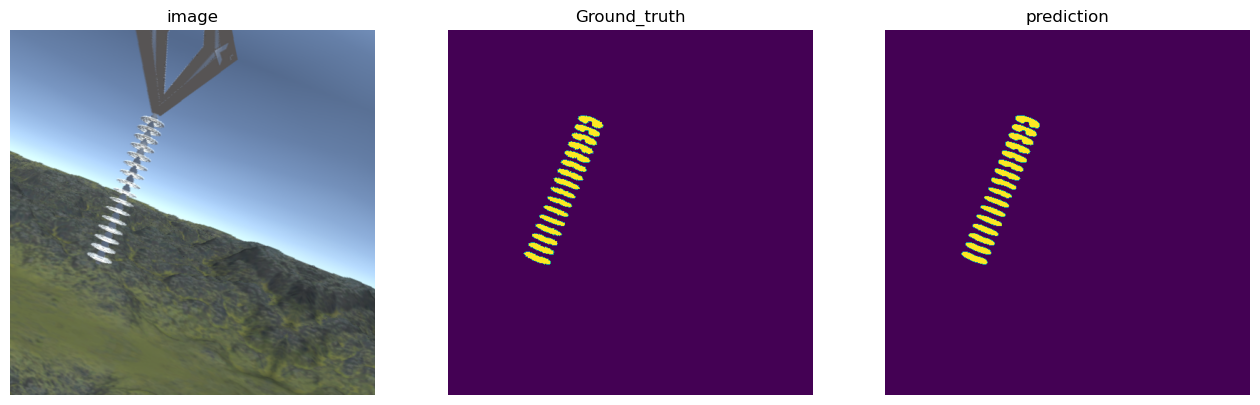

In [21]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [22]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_glass.pth')

In [23]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_glass.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_20384\1479616208.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [24]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [26]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [27]:
real_data = SegmentDataset(dir,2,transform=transform )

In [28]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [29]:
#images, masks = next(iter(real_dataloader))

In [30]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [31]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [32]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [33]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()